### Numerical Experiments

First experiment: adaptivity of the sparse grid is tested

In [5]:
import HPO

import pysgpp

import matplotlib.pyplot as plt

import tensorflow as tf

import sklearn.metrics

from sklearn.model_selection import KFold

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor, KerasClassifier


VERBOSE = 1
CV = 2 #[(slice(None), slice(None))]
TESTING = False

DATASETS = []

RESULTS = []

COSTS = []

### Hyperparameter space definition

In [6]:
ITER = 3

ADAPTIVITIES = [0.0, 0.25, 0.5, 0.75, 0.8, 1]


hyperparameterspace = {
    'epochs': ["interval-int", 1, 2],
    'batch_size': ["interval-int", 10, 200],
    'optimizer__learning_rate': ["interval-log", 0.0000001, 0.01],
    #'model__neurons_per_layer': ["interval-int", 1, 100],
    #'model__number_of_layers': ["interval-int", 1, 10],
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

In [7]:
ids = [233214, 233211]#, 359935, 359952, 359940, 359931, 317614, 359949, 359934, 359946, 359938, 359932, 359943]

RESULTS = [[[] for _ in range(len(ADAPTIVITIES))] for _ in range(len(ids))]
RESULTS_OPTIMIZED = [[[] for _ in range(len(ADAPTIVITIES))] for _ in range(len(ids))]
COSTS = [[[] for _ in range(len(ADAPTIVITIES))] for _ in range(len(ids))]

def relu_advanced(x):
    return K.relu(x)

ACTIVATION_FUNCTION = relu_advanced

INITIALIZER = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3, seed=42)

valid_datasets = 0
for i in range(len(ids)):
    print("######################################################################################################################################################")
    print("Current Dataset:", (i+1), "of", len(ids), "with id:", ids[i])

    dataset = HPO.Dataset(ratio=0.9, task_id=ids[i])

    def evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers):
        
        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION, kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
            for _ in range(number_of_layers):
                model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION, kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
            model.add(Dense(1, activation=None))
            # Compile model
            
            optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

            model.compile(loss=loss, optimizer=optimizer)
            return model


        kfold = KFold(n_splits=CV)

        X = dataset.get_X_train().tolist() + dataset.get_X_validation().tolist()
        Y = dataset.get_Y_train().tolist() + dataset.get_Y_validation().tolist()
        
        if TESTING:
            X += dataset.get_X_test().tolist()
            Y += dataset.get_Y_test().tolist()

        X = np.array(X)
        Y = np.array(Y)

        split = (kfold.split(X, Y))

        values = []

        for i, (train_index, test_index) in enumerate(split):
            X_train = X[train_index]
            Y_train = Y[train_index]

            X_val = X[test_index]
            Y_val = Y[test_index]


            model = KerasRegressor(model=create_model, verbose=0)

            model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)

            Y_predicted = model.predict(X_val)
            error = sklearn.metrics.mean_squared_error(Y_predicted, Y_val)
            values.append(error)

            K.clear_session()
            del model

        result = sum(values)/len(values)
        return result
        
    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(len(hyperparameterspace.keys()))


        def eval(self, x):
            #index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
            
            epochs = int(HPO.from_standard(hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

            batch_size = int(HPO.from_standard(hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

            model_learning_rate = HPO.from_standard_log(hyperparameterspace_special["optimizer__learning_rate"][0], hyperparameterspace_special["optimizer__learning_rate"][1], x[2])
            
            neurons_per_layer = 40 # int(HPO.from_standard(hyperparameterspace_special["model__neurons_per_layer"][0], hyperparameterspace_special["model__neurons_per_layer"][1], x[3]))

            number_of_layers = 1 # int(HPO.from_standard(hyperparameterspace_special["model__number_of_layers"][0], hyperparameterspace_special["model__number_of_layers"][1], x[4]))

            return evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers)
            

    ##### For each dataset: run models with different budget #####

    for j in range(ITER):
        BUDGET = (j+2) ** 3
        print("\n################################################## Current Budget:", BUDGET, "##################################################")

        ########################### SPARSE OPT ############################
        print("Performing sparse search")
        
        for a in range(len(ADAPTIVITIES)):
            f = ExampleFunction()

            optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=ADAPTIVITIES[a], optimizer="gradient_descent")

            result = optimization.fit()

            TESTING = True
            RESULTS[i][a].append(f.eval(result[0]))
            RESULTS_OPTIMIZED[i][a].append(f.eval(result[1]))
            #TESTING = False

            COSTS[i][a].append(result[2])

            K.clear_session()

        print(RESULTS)
        print(RESULTS_OPTIMIZED)
        print(COSTS)

    


######################################################################################################################################################
Current Dataset: 1 of 2 with id: 233214

################################################## Current Budget: 8 ##################################################
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...


2023-04-26 11:17:19.656929: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Done in 49948ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 1.5
batch_size: 105.0
optimizer__learning_rate: 0.0005623413251903491
Resulting loss:
442.9210262541483
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 1.5
batch_size: 105.0
optimizer__learning_rate: 0.0005623413251903491
Resulting loss (Optimal value from optimization):
-2089.596675354542
Resulting loss (Optimal point evaluated):
96.30796082040737
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 50055ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 1.5
batch_size: 152.5
optimizer__learning_rate: 3.1622776601683795e-05
Resulting loss:
594.616873255311
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 1.5
batch_size: 200.0
optimizer__learning_rate: 3.1622776601683795

### Plotting

[[[57, 15, 10], [57, 15, 10], [57, 15, 10], [57, 15, 10], [57, 15, 10], [57, 57, 33]], [[57, 15, 10], [57, 15, 10], [57, 15, 10], [57, 15, 10], [57, 15, 10], [57, 57, 33]]]
[[[10, 10, 10], [10, 10, 10], [10, 10, 10], [10, 10, 10], [10, 10, 10], [10, 10, 10]], [[10, 10, 10], [10, 10, 10], [10, 10, 10], [10, 10, 10], [10, 10, 10], [10, 10, 10]]]
[[[7, 25, 61], [7, 25, 61], [7, 25, 61], [7, 25, 61], [7, 25, 61], [7, 25, 61]], [[7, 25, 61], [7, 25, 61], [7, 25, 61], [7, 25, 61], [7, 25, 61], [7, 25, 61]]]
Current dataset: 0 with name id: 233214


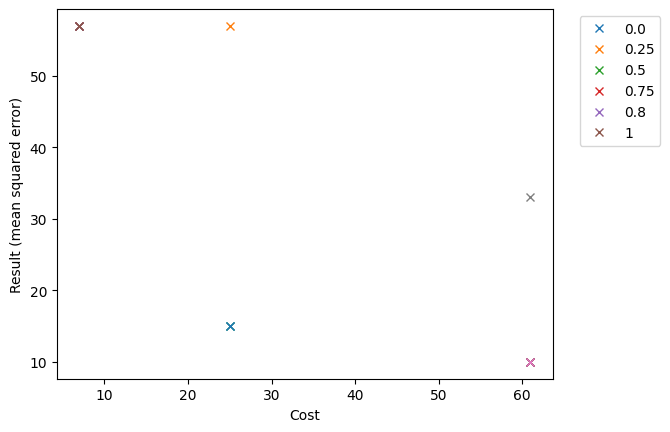

Current dataset: 1 with name id: 233211


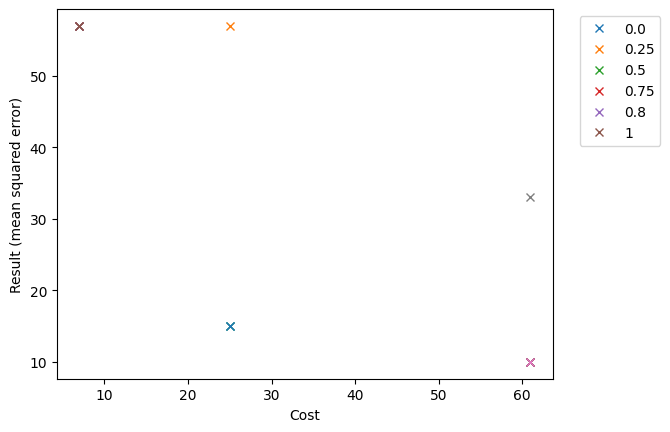

In [ ]:
print(RESULTS)
print(RESULTS_OPTIMIZED)
print(COSTS)

for i in range(len(ids)):
    print("Current dataset:", i, "with name id:", ids[i])
    for j in range(ITER):
        for a in range(len(ADAPTIVITIES)):
            plt.plot(COSTS[i][a][j], RESULTS[i][a][j], "x")
            plt.plot(COSTS[i][a][j], RESULTS_OPTIMIZED[i][a][j], "+")
        plt.xlabel("Cost")
        plt.ylabel("Result (mean squared error)")
        #plt.yscale("log")
        legend = [str(adaptivity) for adaptivity in ADAPTIVITIES]
        plt.legend(legend, bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.show()

